<a href="https://colab.research.google.com/github/rahiakela/math-for-programmers/blob/main/3-ascending-to-3d-world/5_rendering_3d_object_in_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Rendering a 3D object in 2D

Let’s try using what we’ve learned to render a simple
3D shape called an octahedron. Whereas a cube has
six faces, all of which are squares, an octahedron has
eight faces, all of which are triangles. You can think of
an octahedron as two, four-sided pyramids stacked on
top of each other.

<img src='https://github.com/rahiakela/img-repo/blob/master/math-for-programmers/octahedron.png?raw=1' width='200'/>

If this were a solid, we wouldn’t be able to see the
opposite sides.

Rendering the octahedron comes down to identifying the four triangles we need to show and shading them appropriately.

## Setup

In [ ]:
%%shell

wget https://raw.githubusercontent.com/rahiakela/math-for-programmers/main/3-ascending-to-3d-world/vectors.py
wget https://raw.githubusercontent.com/rahiakela/math-for-programmers/main/3-ascending-to-3d-world/colors.py
wget https://raw.githubusercontent.com/rahiakela/math-for-programmers/main/3-ascending-to-3d-world/draw2d.py
wget https://raw.githubusercontent.com/rahiakela/math-for-programmers/main/3-ascending-to-3d-world/draw3d.py

In [2]:
from draw3d import *
from draw2d import *
from vectors import *

%load_ext autoreload
%autoreload 2

## Defining a 3D object with vectors

An octahedron is an easy example because it has only
six corners or vertices. We can give them simple coordinates:
`(1, 0, 0), (0, 1, 0), (0, 0, 1)` and their three
opposite vectors.

<img src='https://github.com/rahiakela/img-repo/blob/master/math-for-programmers/octahedron-vertices.png?raw=1' width='800'/>

These six vectors define the boundaries of the
shape but don’t provide all the information we need
to draw it. We also need to decide which of these vertices
connect to form edges of the shape.

For instance, the top point is (0, 0, 1) and it connects
by an edge to all four points in the x,y plane.

These edges outline the top pyramid of the octahedron. Note that there is no edge from (0, 0, 1) to (0, 0, –1) because that segment would lie within the octahedron, not on its outside. Each edge is defined by a pair of vectors: the start and end points of the edge as a line segment. For instance, (0, 0, 1) and (1, 0, 0) define one of the edges.

Edges still aren’t enough data to complete the drawing. We also need to know
which triples of vertices and edges define the triangular faces we want to fill with a solid, shaded color. Here’s where orientation comes in: we want to know not only which segments define faces of the octahedron, but also whether they face toward us or away from us.

Here’s the strategy: we’ll model a triangular face as three vectors v1, v2, and v3, defining its edges. (Note that here I use subscripts 1, 2, and 3 to distinguish three different vectors, not components of the same vector.) Specifically, we’ll order v1, v2, and v3 such that (v2 – v1) × (v3 – v1) points outside the octahedron. If an outward-pointing vector is aimed toward us, it means the face is visible from our perspective. Otherwise, the face is obscured and we won’t need to draw it.

<img src='https://github.com/rahiakela/img-repo/blob/master/math-for-programmers/octahedron-face.png?raw=1' width='800'/>

We can define the eight triangular faces as triples of three vectors v1, v2, and v3 as follows:







In [3]:
octahedron = [
  [(1,0,0), (0,1,0), (0,0,1)],
  [(1,0,0), (0,0,-1), (0,1,0)],
  [(1,0,0), (0,0,1), (0,-1,0)],
  [(1,0,0), (0,-1,0), (0,0,-1)],
  [(-1,0,0), (0,0,1), (0,1,0)],
  [(-1,0,0), (0,1,0), (0,0,-1)],
  [(-1,0,0), (0,-1,0), (0,0,1)],
  [(-1,0,0), (0,0,-1), (0,-1,0)],            
]

The faces are actually the only data we need to render the shape; these contain the edges and vertices implicitly.

In [4]:
def vertices(faces):
  return list(set([vertex for face in faces for vertex in face]))

## Projecting to 2D

To turn 3D points into 2D points, we must choose what 3D direction we are observing from. Once we have two 3D vectors defining “up” and “right” from our perspective, we can project any 3D vector onto them and get two components instead of three.

Let's extracts the part of any 3D vector pointing in a given direction
using the dot product:

In [5]:
def dot(u, v):
  return sum([coord1 * coord2 for coord1, coord2 in zip(u, v)])

def component(v, direction):
  return (dot(v, direction) / length(direction))

With two directions, we can establish a way to project from three coordinates down to two. This function takes a 3D vector or a tuple of three numbers and returns a 2D vector or a tuple of two numbers:

In [6]:
def vector_to_2d(v):
  return (component(v, (1, 0, 0)), component(v, (0, 1, 0)))

We can picture this as “flattening” the 3D vector into the plane. Deleting the z component takes away any depth the vector has.

<img src='https://github.com/rahiakela/img-repo/blob/master/math-for-programmers/3d-flattens.png?raw=1' width='800'/>

Finally, to take a triangle from 3D to 2D, we need only apply this function to all of the vertices defining a face:

In [7]:
def face_to_2d(face):
  return [vector_to_2d(vertex) for vertex in face]

## Orienting faces and shading

To shade our 2D drawing, we pick a fixed color for each triangle according to how much it faces a given light source. Let’s say our light source lies at a vector of (1, 2, 3) from the origin. Then the brightness of a triangular face is decided by how close to perpendicular it is to the light. 

Another way to measure this is by how aligned a perpendicular
vector to the face is with the light source. We don’t have to worry about
computing colors; Matplotlib has a built-in library to do that for us.

In [8]:
blues = matplotlib.cm.get_cmap("Blues")

Given a vector perpendicular (or normal) to each face and a vector pointing to the light source, their dot product tells us how aligned they are. Moreover, because we’re only considering directions, we can choose vectors with length 1. Then, if the face is pointing toward the light source at all, the dot product will lie between 0 and 1. If it is further than 90° from the light source, it will not be illuminated at all.

This helper function takes a vector and returns another in the same direction but with length 1:

In [9]:
def unit(v):
  return scale(1. / length(v), v)

This second helper function takes a face and gives us a vector perpendicular to it:

In [10]:
def normal(face):
  return (cross(subtract(face[1], face[0]), subtract(face[2], face[0])))

Putting it all together, we have a function that draws all the triangles we need to render a 3D shape using our draw function.

In [11]:
def render(faces, light=(1, 2, 3), color_map=blues, lines=None):
  polygons = []
  for face in faces:
    # For each face, computes a vector of length 1 perpendicular to it
    unit_normal = unit(normal(face))
    # Only proceeds if the z component of this vector is positive, or in other words, if it points toward the viewer
    if unit_normal[2] > 0:
      # The larger the dot product between the normal vector and the light source vector, the less shading
      c = color_map(1 - dot(unit(normal(face)), unit(light)))
      # Specifies an optional lines argument for the edges of each triangle, revealing the skeleton of the shape we’re drawing
      p = Polygon2D(*face_to_2d(face), fill=c, color=lines)
      polygons.append(p)
  
  draw2d(*polygons, axes=False, origin=False, grid=None)

With the following render function, it only takes a few lines of code to produce an octahedron.

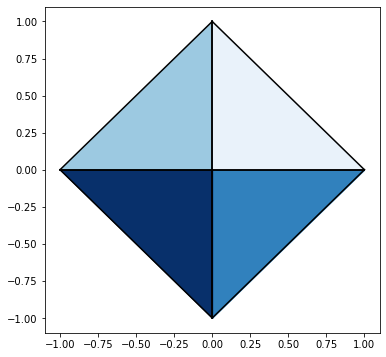

In [12]:
render(octahedron, color_map=matplotlib.cm.get_cmap("Blues"), lines=black)

The shaded octahedron doesn’t look that special from the side, but adding more
faces, we can tell that the shading is working.

In [13]:
def split(face):
  midpoints = [unit(add(face[i], face[(i+1)%len(face)])) for i in range(0,len(face))]
  triangles = [(face[i], midpoints[i], midpoints[(i-1)%len(face)]) for i in range(0,len(face))]
  return [midpoints] + triangles

def rec_split(faces, depth=0):
  if depth == 0:
    return faces
  else:
    return rec_split([new_face for face in faces for new_face in split(face)], depth-1)

# NICE SPHERE!
def sphere_approx(n):
  return rec_split(octahedron, n)

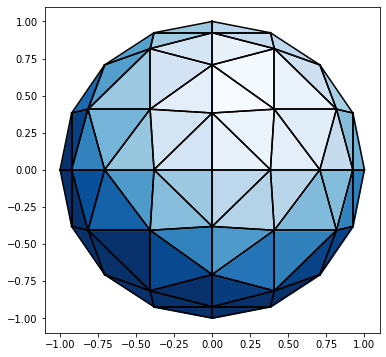

In [14]:
render(sphere_approx(2), lines="k")

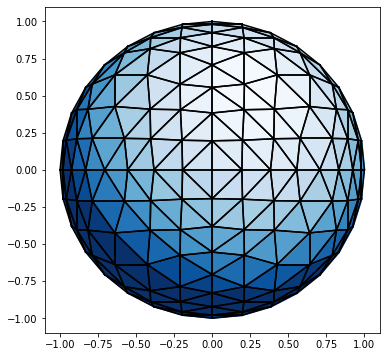

In [15]:
render(sphere_approx(3), lines="k")

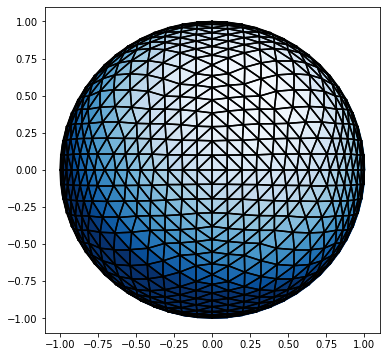

In [16]:
render(sphere_approx(4), lines="k")

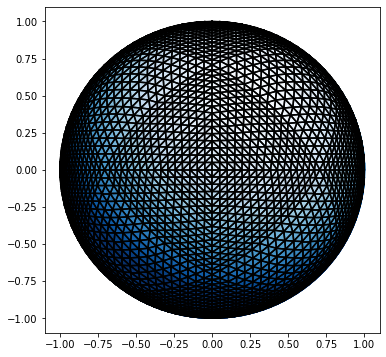

In [17]:
render(sphere_approx(5), lines="k")

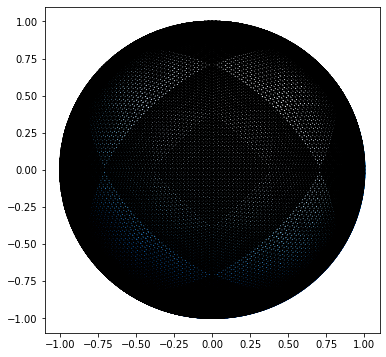

In [18]:
render(sphere_approx(6), lines="k")

## Exercises

**Ex-3.27**: Find pairs of vectors defining each of the 12 edges
of the octahedron and draw all of the edges in Python.

**Solution** The top of the octahedron is (0, 0, 1). It connects to all four points in the x,y plane via four edges. Likewise, the bottom of the octahedron is (0, 0, –1) and it also connects to all four points in the x,y plane. Finally, the four points in the x,y plane connect to each other in a square:

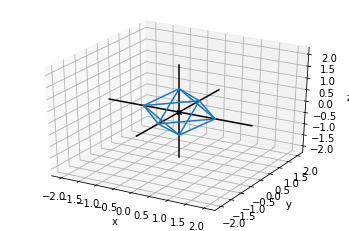

In [19]:
top = (0,0,1)
bottom = (0, 0, -1)
xy_plane = [(1,0,0),(0,1,0),(-1,0,0),(0,-1,0)]

edges = [Segment3D(top, p) for p in xy_plane] + [Segment3D(bottom, p) for p in xy_plane] + [Segment3D(xy_plane[i], xy_plane[(i + 1) % 4]) for i in range(0, 4)]
draw3d(*edges)